In [3]:
# try everything here
import sys
import networkx as nx # type: ignore
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dowhy import CausalModel

sys.path.append('../')
from src.data.make_dataset import load_data, merge_all_datasets
from src.data.preprocess import preprocessing

In [4]:
# Loading Data
data_dict = load_data()

olist_customers_df = data_dict['olist_customers_df']
olist_geolocation_df = data_dict['olist_geolocation_df']
olist_order_items_df = data_dict['olist_order_items_df']
olist_order_payments_df = data_dict['olist_order_payments_df']
olist_order_reviews_df = data_dict['olist_order_reviews_df']
olist_orders_df = data_dict['olist_orders_df']
olist_products_df = data_dict['olist_products_df']
olist_sellers_df = data_dict['olist_sellers_df']
product_category_name_translation_df = data_dict['product_category_name_translation_df']

olist_closed_deals_df = data_dict['olist_closed_deals_df']
olist_marketing_qualified_leads_df = data_dict['olist_marketing_qualified_leads_df']

In [5]:
df = merge_all_datasets(olist_customers_df, 
                       olist_geolocation_df,
                       olist_order_items_df,
                       olist_order_payments_df,
                       olist_order_reviews_df, 
                       olist_orders_df,
                       olist_products_df, 
                       olist_sellers_df
                       )

In [6]:
rainfall_categories = {
    'North': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Northeast': {1: 'Low', 2: 'Moderate', 3: 'Moderate', 4: 'High', 5: 'High', 6: 'Moderate', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'Moderate', 12: 'High'},
    'Central-West': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Southeast': {1: 'High', 2: 'High', 3: 'Moderate', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'South': {1: 'Moderate', 2: 'Moderate', 3: 'Moderate', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'Moderate', 12: 'High'}
}

state_to_region = {
    'AC': 'North', 'AP': 'North', 'AM': 'North', 'PA': 'North', 'RO': 'North', 'RR': 'North', 'TO': 'North',
    'AL': 'Northeast', 'BA': 'Northeast', 'CE': 'Northeast', 'MA': 'Northeast', 'PB': 'Northeast', 'PE': 'Northeast', 'PI': 'Northeast', 'RN': 'Northeast', 'SE': 'Northeast',
    'GO': 'Central-West', 'MT': 'Central-West', 'MS': 'Central-West', 'DF': 'Central-West',
    'ES': 'Southeast', 'MG': 'Southeast', 'RJ': 'Southeast', 'SP': 'Southeast',
    'PR': 'South', 'RS': 'South', 'SC': 'South'
}


def get_rainfall_category(region, month):

    rainfall_categories = {
    'North': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Northeast': {1: 'Low', 2: 'Moderate', 3: 'Moderate', 4: 'High', 5: 'High', 6: 'Moderate', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'Moderate', 12: 'High'},
    'Central-West': {1: 'High', 2: 'High', 3: 'High', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Low', 10: 'Moderate', 11: 'High', 12: 'High'},
    'Southeast': {1: 'High', 2: 'High', 3: 'Moderate', 4: 'Moderate', 5: 'Low', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'High', 12: 'High'},
    'South': {1: 'Moderate', 2: 'Moderate', 3: 'Moderate', 4: 'Moderate', 5: 'Moderate', 6: 'Low', 7: 'Low', 8: 'Low', 9: 'Moderate', 10: 'Moderate', 11: 'Moderate', 12: 'High'}
    }

    return rainfall_categories.get(region).get(month, 'Unknown')

In [7]:
df = df.sort_values(by=['customer_id', 'review_answer_timestamp'])

# Create a new column for the rolling mean of previous product ratings
def rolling_mean_excluding_last(group):
    return group['review_score'].shift(1).expanding().mean()
df['customer_experience'] = df.groupby('customer_id').apply(rolling_mean_excluding_last).reset_index(drop=True)

# If no previous ratings, use the current rating
df['customer_experience'] = df['customer_experience'].fillna(df['review_score'])

/var/folders/x_/m3z73_rj2pg1h_phvc6592lr0000gq/T/ipykernel_39938/3794632772.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['customer_experience'] = df.groupby('customer_id').apply(rolling_mean_excluding_last).reset_index(drop=True)


In [8]:
df = df.sort_values(by=['seller_id', 'review_answer_timestamp'])

# Create a new column for the rolling mean of previous product ratings
def rolling_mean_excluding_last(group):
    return group['review_score'].shift(1).expanding().mean()
df['seller_avg_rating'] = df.groupby('seller_id').apply(rolling_mean_excluding_last).reset_index(drop=True)

# If no previous ratings, use the current rating
df['seller_avg_rating'] = df['seller_avg_rating'].fillna(df['review_score'])

/var/folders/x_/m3z73_rj2pg1h_phvc6592lr0000gq/T/ipykernel_39938/939435977.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['seller_avg_rating'] = df.groupby('seller_id').apply(rolling_mean_excluding_last).reset_index(drop=True)


In [9]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'geolocation_zip_code_prefix_x', 'geolocation_lat_x',
       'geolocation_lng_x', 'geo

In [33]:
df[['order_purchase_timestamp','seller_state']]

,order_purchase_timestamp,seller_state
0,2017-09-26 22:17:05,SP
2,2017-10-12 13:33:22,SP
1,2017-10-18 08:16:34,SP
26,2017-02-18 23:26:24,ES
27,2017-02-18 23:26:24,ES
...,...,...
118873,2017-06-09 20:25:03,NaN
118899,2018-01-18 23:14:36,NaN
119057,2017-12-08 09:32:48,NaN
119102,2017-02-06 08:18:30,NaN


In [34]:
def get_rainfall_category(row):
    if pd.isnull(row['seller_state']) or pd.isnull(row['order_purchase_timestamp']):
        return 'Unknown'

    month = pd.to_datetime(row['order_purchase_timestamp']).month
    region = state_to_region.get(row['seller_state'])
    
    if region:
        return rainfall_categories[region].get(month, 'Unknown')
    return 'Unknown'

# Apply the function to create the new variable
df['rain_level'] = df.apply(get_rainfall_category, axis=1)

# Display the DataFrame
print(df)

                                order_id                       customer_id  \
0       d455a8cb295653b55abda06d434ab492  944b72539d7e1f7f7fc6e46639ef1fe3   
2       9dc8d1a6f16f1b89874c29c9d8d30447  d9442164acf4b03109425633efaa0cfc   
1       7f39ba4c9052be115350065d07583cac  d7fc82cbeafea77bd0a8fbbf6296e387   
26      eb188a175542057d90b3ca5628b7b5a0  1eda56b47988d592fec945da9ee88c56   
27      eb188a175542057d90b3ca5628b7b5a0  1eda56b47988d592fec945da9ee88c56   
...                                  ...                               ...   
118873  974f9f87a3bad01b2ac72fe987505e9b  b8bd03cdd075b29c82a9c55e5cd8e224   
118899  0a5c74ccc786ced7903270de9d6c170a  c021456db05f8e71f0985bef8859b793   
119057  2f30c0b1905c65a8ff6c6358bc909625  e963d0e4f815dcd28b135d7d340ec51a   
119102  5f2dbe00a1732133a6809ae1af554123  f7b1d4b064c31b564fd39ad8bcb7cbdc   
119126  a536059a071793ef05e7e63cbac9d50e  fc475d3aba4d37f81edce933ce07ed1b   

       order_status order_purchase_timestamp   order_approved_a

In [35]:
df[['order_purchase_timestamp','seller_state', 'rain_level']]

,order_purchase_timestamp,seller_state,rain_level
0,2017-09-26 22:17:05,SP,Moderate
2,2017-10-12 13:33:22,SP,Moderate
1,2017-10-18 08:16:34,SP,Moderate
26,2017-02-18 23:26:24,ES,High
27,2017-02-18 23:26:24,ES,High
...,...,...,...
118873,2017-06-09 20:25:03,NaN,Unknown
118899,2018-01-18 23:14:36,NaN,Unknown
119057,2017-12-08 09:32:48,NaN,Unknown
119102,2017-02-06 08:18:30,NaN,Unknown


In [39]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'geolocation_zip_code_prefix_x', 'geolocation_lat_x',
       'geolocation_lng_x', 'geo

In [40]:
final_df = preprocessing(df=df, state_to_region=state_to_region)

In [41]:
final_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'payment_value', 'review_id', 'review_score',
       'month', 'rainfall', 'Product_weight_kg', 'Product_category',
       'Product_size', 'No_photos', 'Product_price', 'seasonality',
       'is_delivery_late', 'geolocation_lat_x', 'geolocation_lng_x',
       'geolocation_lat_y', 'geolocation_lng_y', 'freight_value',
       'distance_km', 'Product_category_encoded', 'customer_experience',
       'seller_avg_rating'],
      dtype='object')

In [42]:
final_df.rename(columns={
    'seasonality': 'season',
    'review_score': 'Rating',
    'rainfall': 'region'
    
}, inplace=True)

In [43]:
df_final = final_df[['order_id', 
               'payment_value', 
               'Rating',
               'region', 
               'Product_weight_kg', 
               'distance_km',
               'Product_category', 
               'Product_size', 
               'No_photos',
               'Product_price', 
               'season', 
               'is_delivery_late',
               'Product_price',
               'freight_value',
               'Product_category_encoded', 
               'seller_avg_rating',
               'customer_experience', 
               'rain_level']]

KeyError: "['rain_level'] not in index"

In [36]:
df_final.columns

Index(['order_id', 'payment_value', 'Rating', 'region', 'Product_weight_kg',
       'distance_km', 'Product_category', 'Product_size', 'No_photos',
       'Product_price', 'season', 'is_delivery_late', 'Product_price',
       'freight_value', 'Product_category_encoded', 'seller_avg_rating',
       'customer_experience'],
      dtype='object')

In [14]:
df_final.to_csv("../data/processed/data.csv", index=False)

# EDA

In [15]:
#Basic overview
print("\nDataset Shape:", df_final.shape)
print("\nColumn Data info:")
print(df_final.info())


Dataset Shape: (119143, 17)

Column Data info:
<class 'pandas.core.frame.DataFrame'>
Index: 119143 entries, 0 to 119126
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  119143 non-null  object 
 1   payment_value             119140 non-null  float64
 2   Rating                    118146 non-null  float64
 3   region                    119143 non-null  object 
 4   Product_weight_kg         118290 non-null  float64
 5   distance_km               117729 non-null  float64
 6   Product_category          116601 non-null  object 
 7   Product_size              118290 non-null  float64
 8   No_photos                 116601 non-null  float64
 9   Product_price             118310 non-null  float64
 10  season                    119143 non-null  int32  
 11  is_delivery_late          119143 non-null  int64  
 12  Product_price             118310 non-null  float64
 13  f

In [16]:
# Descriptive Statistics
numerical_cols = ['payment_value', 'Rating', 'Product_weight_kg', 'distance_km', 
                  'No_photos', 'Product_price', 'freight_value', 
                  'Product_category_encoded', 'seller_avg_rating']
print(df_final[numerical_cols].describe())

       payment_value         Rating  Product_weight_kg    distance_km  \
count  119140.000000  118146.000000      118290.000000  117729.000000   
mean      172.735135       4.015582           2.112251     597.223947   
std       267.776077       1.400436           3.786695     589.237602   
min         0.000000       1.000000           0.000000       0.000000   
25%        60.850000       4.000000           0.300000     187.653367   
50%       108.160000       5.000000           0.700000     431.950458   
75%       189.240000       5.000000           1.800000     792.236663   
max     13664.080000       5.000000          40.425000    8677.911622   

           No_photos  Product_price  Product_price  freight_value  \
count  116601.000000  118310.000000  118310.000000  118310.000000   
mean        2.205161     120.646603     120.646603      20.032387   
std         1.717452     184.109691     184.109691      15.836850   
min         1.000000       0.850000       0.850000       0.000000 

In [17]:
# Categorical Columns Analysis
categorical_cols = ['region', 'Product_category', 'Product_size', 'season', 
                   'is_delivery_late', 'customer_experience']

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df_final[col].value_counts().nlargest(10))
    print(f"{col} unique values:", df_final[col].nunique())


region value counts:
region
Southeast       81962
South           16961
Northeast       11079
Central-West     6976
North            2165
Name: count, dtype: int64
region unique values: 5

Product_category value counts:
Product_category
cama_mesa_banho           11988
beleza_saude              10032
esporte_lazer              9004
moveis_decoracao           8832
informatica_acessorios     8150
utilidades_domesticas      7380
relogios_presentes         6213
telefonia                  4726
ferramentas_jardim         4590
automotivo                 4400
Name: count, dtype: int64
Product_category unique values: 73

Product_size value counts:
Product_size
8000.0     2816
352.0      1906
19800.0    1311
4096.0     1213
640.0      1128
816.0      1116
27000.0    1009
2560.0      976
4800.0      965
4500.0      946
Name: count, dtype: int64
Product_size unique values: 4525

season value counts:
season
8     12802
5     12743
7     12325
3     11858
6     11256
4     11155
2     10180
1      9

In [18]:
regional_stats = df_final.groupby('region').agg({
    'payment_value': ['mean', 'count'],
    'Rating': 'mean',
    'freight_value': 'mean'
}).round(2)
print(regional_stats)

             payment_value        Rating freight_value
                      mean  count   mean          mean
region                                                
Central-West        198.40   6976   3.98         23.22
North               230.42   2165   3.92         37.09
Northeast           214.28  11079   3.84         32.08
South               179.31  16961   4.04         21.28
Southeast           162.05  81959   4.04         17.42


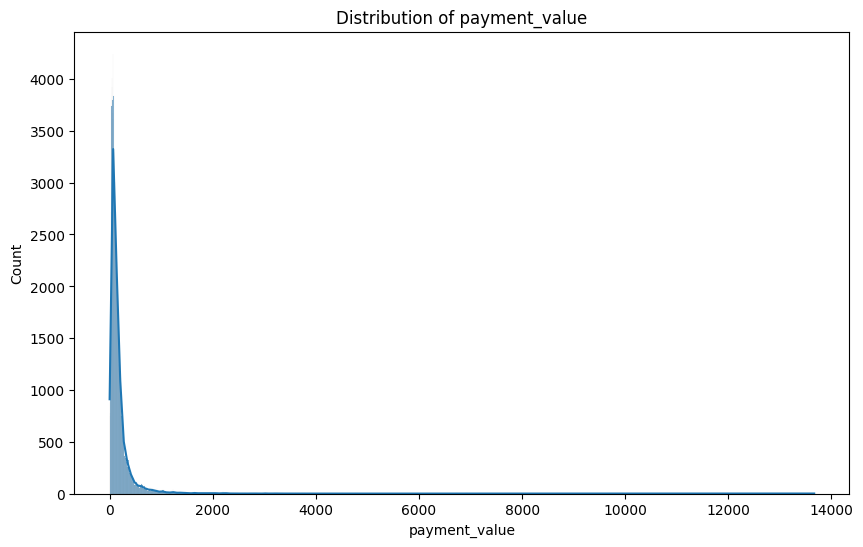

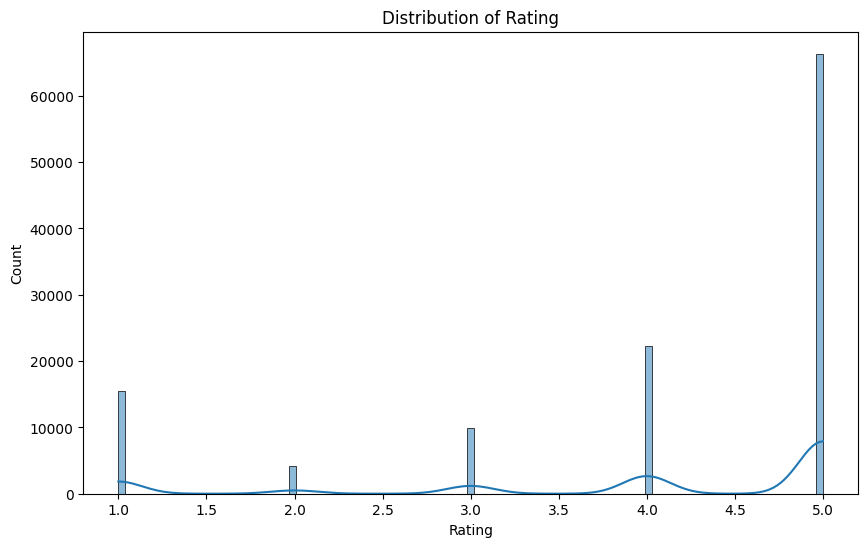

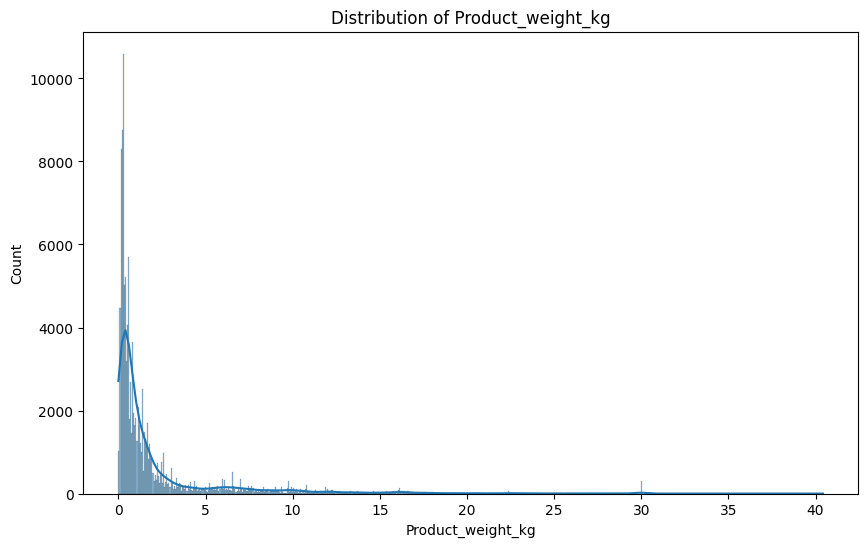

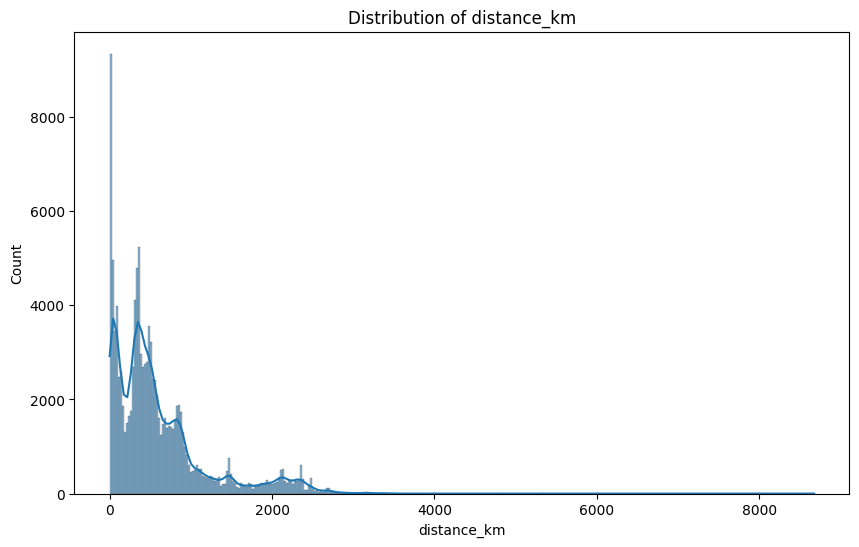

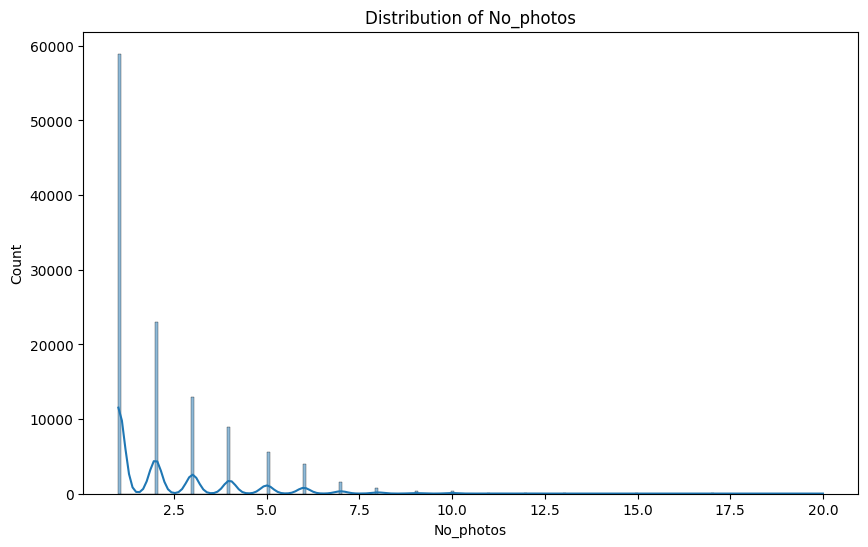

ValueError: If using all scalar values, you must pass an index

<Figure size 1000x600 with 0 Axes>

In [19]:
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_final, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

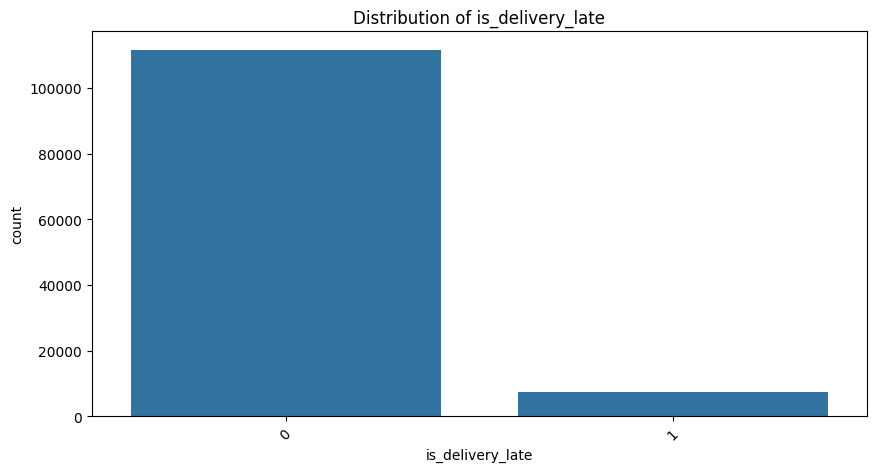

In [20]:
categorical_cols = ['is_delivery_late']

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_final, x=col)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()


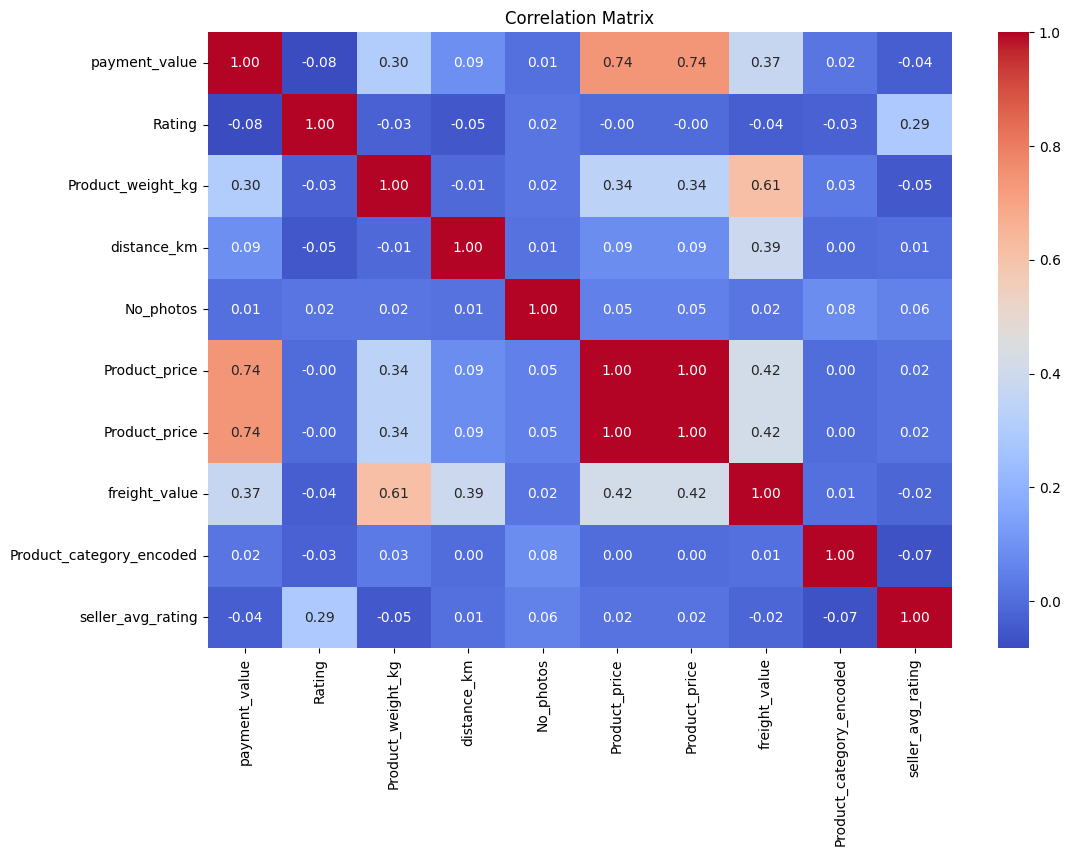

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_final[numerical_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [22]:
# Product category analysis

category_stats = df_final.groupby('Product_category').agg({
    'payment_value': ['mean', 'count'],
    'Rating': 'mean'
}).round(2)
print(category_stats)

                          payment_value       Rating
                                   mean count   mean
Product_category                                    
agro_industria_e_comercio        471.15   252   4.15
alimentos                         88.27   526   4.23
alimentos_bebidas                 94.41   291   4.32
artes                            141.52   219   3.94
artes_e_artesanato                96.92    24   4.12
...                                 ...   ...    ...
sinalizacao_e_seguranca          340.74   201   4.06
tablets_impressao_imagem         115.44    87   4.12
telefonia                        103.09  4726   3.95
telefonia_fixa                   761.29   272   3.67
utilidades_domesticas            148.77  7380   4.06

[73 rows x 3 columns]


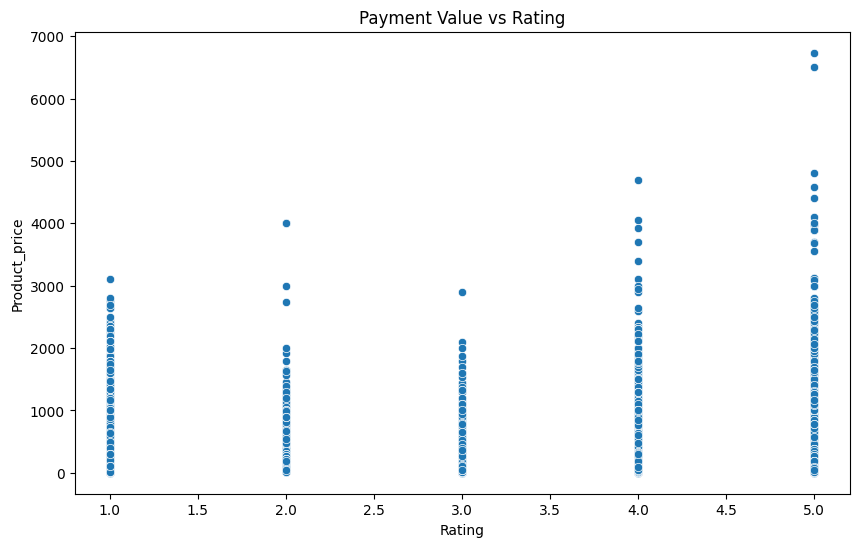

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Rating', y='Product_price')
plt.title('Payment Value vs Rating')
plt.show()

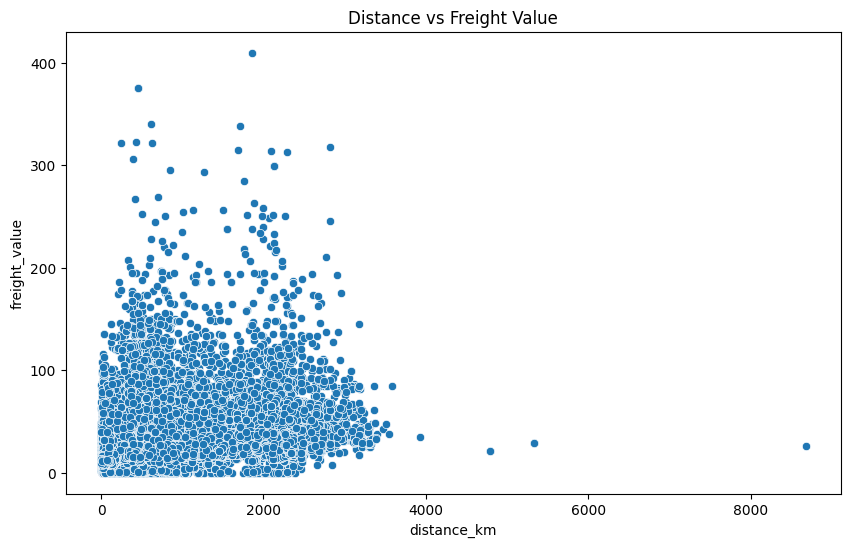

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='distance_km', y='freight_value')
plt.title('Distance vs Freight Value')
plt.show()

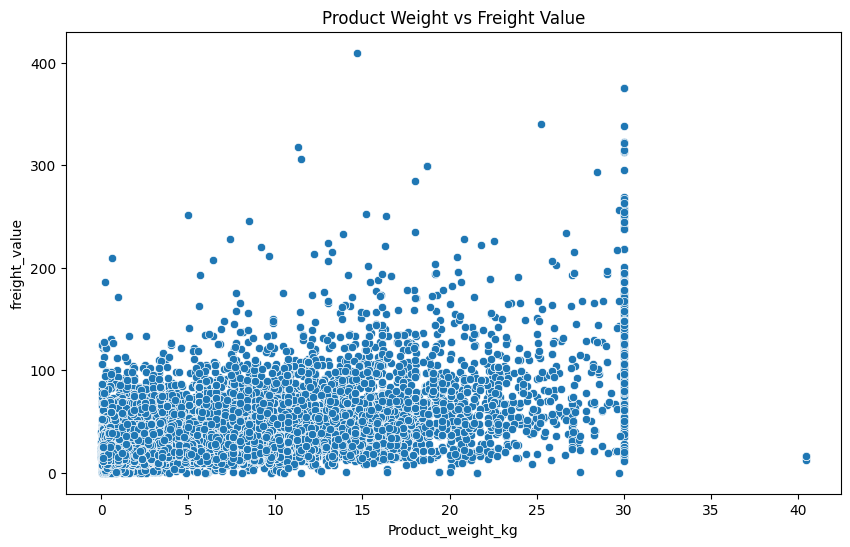

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Product_weight_kg', y='freight_value')
plt.title('Product Weight vs Freight Value')
plt.show()

In [26]:
from scipy import stats
# ANOVA test for payment value across seasons
f_stat, p_val = stats.f_oneway(*[group['payment_value'].values 
                                 for name, group in df_final.groupby('season')])
print(f"ANOVA test for payment value across seasons: f_stat={f_stat:.4f}, p_value={p_val:.4f}")

ANOVA test for payment value across seasons: f_stat=nan, p_value=nan


In [27]:
print("\n7. Key Metrics:")
print(f"Average payment value: {df_final['payment_value'].mean():.2f}")
print(f"Average rating: {df_final['Rating'].mean():.2f}")
print(f"Average shipping distance: {df_final['distance_km'].mean():.2f} km")
print(f"Most common product category: {df_final['Product_category'].mode()[0]}")


7. Key Metrics:
Average payment value: 172.74
Average rating: 4.02
Average shipping distance: 597.22 km
Most common product category: cama_mesa_banho


In [28]:
df_final.head()

,order_id,payment_value,Rating,region,Product_weight_kg,distance_km,Product_category,Product_size,No_photos,Product_price,season,is_delivery_late,Product_price,freight_value,Product_category_encoded,seller_avg_rating,customer_experience
0,d455a8cb295653b55abda06d434ab492,916.02,5.0,South,11.800,687.434185,eletroportateis,61920.0,2.0,895.0,9,0,895.0,21.02,31,5.000000,5.0
2,9dc8d1a6f16f1b89874c29c9d8d30447,916.02,5.0,Southeast,11.800,714.295670,eletroportateis,61920.0,2.0,895.0,10,0,895.0,21.02,31,5.000000,5.0
1,7f39ba4c9052be115350065d07583cac,916.02,1.0,Southeast,11.800,417.139650,eletroportateis,61920.0,2.0,895.0,10,0,895.0,21.02,31,5.000000,1.0
26,eb188a175542057d90b3ca5628b7b5a0,573.85,4.0,Southeast,8.875,523.615247,ferramentas_jardim,24080.0,4.0,99.9,2,0,99.9,14.87,40,3.695652,4.0
27,eb188a175542057d90b3ca5628b7b5a0,573.85,4.0,Southeast,8.875,523.615247,ferramentas_jardim,24080.0,4.0,99.9,2,0,99.9,14.87,40,3.625000,4.0


In [32]:
df_final.groupby('season')['is_delivery_late'].agg('sum')

season
1      503
2     1148
3     1640
4      503
5      652
6      196
7      378
8      580
9      224
10     210
11    1051
12     474
Name: is_delivery_late, dtype: int64